# Brooklyn, NYC, USA Skate Parks Analysis
### Capstone Project - The Battle of the Neighborhoods (Week 5)

# Data <a name="data"></a>

The data I will need for Brooklyn is as follows:

## -- Brooklyn Neighborhoods By Population --

-  Table of Brooklyn's main neighbourhoods and their population from ([Brooklyn Neighborhoods By Population](http://www.worldatlas.com/articles/brooklyn-neighborhoods-by-population.html)).

### Pull in Brooklyn's population by Neighbourhood from Brooklyn Neighborhoods By Population

In [1]:
from bs4 import BeautifulSoup
import urllib.request

source = "https://www.worldatlas.com/articles/brooklyn-neighborhoods-by-population.html"
page = urllib.request.urlopen(source)

### Create the BeautifulSoup object

In [2]:
soup = BeautifulSoup(page, "lxml")
print(soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <title>
   Brooklyn Neighborhoods By Population - WorldAtlas.com
  </title>
  <meta charset="utf-8"/>
  <meta content="table" name="content_template"/>
  <meta content="Brooklyn Neighborhoods By Population" name="title"/>
  <meta content="Learn about the most populous neighborhoods of Brooklyn, New York City’s most populated borough." name="description"/>
  <meta content="article" property="og:type"/>
  <meta content="https://www.worldatlas.com/articles/brooklyn-neighborhoods-by-population.html" property="og:url"/>
  <meta content="WorldAtlas" property="og:site_name"/>
  <meta content="Brooklyn Neighborhoods By Population" property="og:title"/>
  <meta content="https://www.worldatlas.com/r/w1200-h701-c1200x701/upload/00/a4/ad/brooklyn-brownstones.jpg" property="og:image"/>
  <meta content="1200" property="og:image:width"/>
  <meta content="701" property="og:image:height"/>
  <meta content="2019-01-30T09:46:00-05:00" property="og:article:publis

### Add the "table" class to the soup object

In [3]:
table=soup.find_all('table')[0]

### Create the dataframe by parsing the 'tr' & 'td' tags

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

A = []
B = []
C = []

# Populate the lists and append to the df
for row in table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))   

#Renaming the colunms
df=pd.DataFrame(A,columns=['Rank'])
df['Neighborhood']=B
df['Population']=C

df.head()

,Rank,Neighborhood,Population
0,1,Bedford-Stuyvesant,"157,530"
1,2,Bensonhurst,"151,705"
2,3,Bushwick,"129,239"
3,4,Sunset Park,"126,000"
4,5,Borough Park,"106,357"


#### Cleaning up the table: Dropping the 'Rank' col and removing the ',' from the population column, and setting the index to the 'Neighbourhood' col for graphing

In [5]:
bneighs = df.drop('Rank', 1)
bneighs['Population'] = [col.replace(',', '') for col in bneighs['Population']]

bneighs['Population'] = bneighs['Population'].astype('int')
bneighs.set_index('Neighborhood', inplace=True)
bneighs.head()

,Population
Neighborhood,
Bedford-Stuyvesant,157530
Bensonhurst,151705
Bushwick,129239
Sunset Park,126000
Borough Park,106357


## -- New York Dataset  --

### Pull in and load the New York dataset

In [6]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc


In [7]:
import json
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

### Load the New York Dataset into a DataFrame

In [8]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

#Create a variable to hold the data
neighborhoods_data = newyork_data['features']

In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [10]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Pull out the Brooklyn Data

In [11]:
brooklyn_data =  neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


### Use geopy library to get the latitude and longitude values of Brooklyn.

In [12]:
# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy.distance

address = 'Brooklyn, NY, USA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


## --  Foursquare --

### Settng up code, Credentials, and version for pulling information from the Foursquare source


In [38]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


### Add function for pulling the venue informaton from Foursquare

In [14]:
def getVenue(names, latitudes, longitudes,tquery, nradius):

    venues_list=[]
#     qry = 'skate park'
    qry = tquery
    #3miles
#     radius = 4828.032
    radius = nradius
    
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            qry,
            radius)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    thevenue = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    thevenue.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(thevenue)

### Pull the Skate park Venue within a 3 mile radius

In [15]:
import requests # library to handle requests
thevenuename = 'skate park'
theradius = 4828.032 #3 miles
# theradius = 1609.344
skate_venues = getVenue(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude'],
                                   tquery=thevenuename,
                                   nradius=theradius                        
                                  )

In [16]:
print(skate_venues.shape)
skate_venues.head(10)

(621, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Owl's Head Park,40.639936,-74.032796,Park
1,Bay Ridge,40.625801,-74.030621,5050 Skatepark,40.628053,-74.074548,Skate Park
2,Bay Ridge,40.625801,-74.030621,Millennium Skate Park,40.640938,-74.030570,Skate Park
3,Bay Ridge,40.625801,-74.030621,Fort Hamilton Roller Hockey,40.638216,-73.999462,Skate Park
4,Bensonhurst,40.611009,-73.995180,Owl's Head Park,40.639936,-74.032796,Park
5,Bensonhurst,40.611009,-73.995180,Skate,40.607003,-73.959730,Skate Park
6,Bensonhurst,40.611009,-73.995180,Fort Hamilton Roller Hockey,40.638216,-73.999462,Skate Park
7,Bensonhurst,40.611009,-73.995180,Millennium Skate Park,40.640938,-74.030570,Skate Park
8,Sunset Park,40.645103,-74.010316,Owl's Head Park,40.639936,-74.032796,Park
9,Sunset Park,40.645103,-74.010316,Homage Skateboard Academy,40.679058,-73.983092,Skate Park


### Need to clean data because the Foursquare data returned every venue that has the word 'park' in it.

In [17]:
skate_parks = skate_venues[skate_venues['Venue Category'].str.contains('Skate Park')].reset_index(drop=True)
skate_parks.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,5050 Skatepark,40.628053,-74.074548,Skate Park
1,Bay Ridge,40.625801,-74.030621,Millennium Skate Park,40.640938,-74.030570,Skate Park
2,Bay Ridge,40.625801,-74.030621,Fort Hamilton Roller Hockey,40.638216,-73.999462,Skate Park
3,Bensonhurst,40.611009,-73.995180,Skate,40.607003,-73.959730,Skate Park
4,Bensonhurst,40.611009,-73.995180,Fort Hamilton Roller Hockey,40.638216,-73.999462,Skate Park


#### Create a function that calculates the distance between the neighbourhood and the skate park.

In [18]:
def get_distance(nlat,nlon,vlat,vlon):
  
    coords_1 = (vlat, vlon)    
    coords_2 = (nlat, nlon)
    
    thedistance = geopy.distance.distance(coords_1, coords_2).miles
    
    return(thedistance) 

#### Populate the new Distance (in miles) column with the calculated distance

In [19]:
result = []
for dneigh_lat, dneigh_lon, dven_lat, dven_lon in zip(skate_parks['Neighborhood Latitude'], 
                                                      skate_parks['Neighborhood Longitude'], 
                                                      skate_parks['Venue Latitude'],
                                                      skate_parks['Venue Longitude']):
    result.append(get_distance(nlat=dneigh_lat,
                               nlon=dneigh_lon,
                               vlat=dven_lat,
                               vlon=dven_lon))
    
skate_parks["Distance (in miles)"]  = result

skate_parks

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance (in miles)
0,Bay Ridge,40.625801,-74.030621,5050 Skatepark,40.628053,-74.074548,Skate Park,2.314581
1,Bay Ridge,40.625801,-74.030621,Millennium Skate Park,40.640938,-74.030570,Skate Park,1.044472
2,Bay Ridge,40.625801,-74.030621,Fort Hamilton Roller Hockey,40.638216,-73.999462,Skate Park,1.848443
3,Bensonhurst,40.611009,-73.995180,Skate,40.607003,-73.959730,Skate Park,1.884572
4,Bensonhurst,40.611009,-73.995180,Fort Hamilton Roller Hockey,40.638216,-73.999462,Skate Park,1.890784
5,Bensonhurst,40.611009,-73.995180,Millennium Skate Park,40.640938,-74.030570,Skate Park,2.779672
6,Sunset Park,40.645103,-74.010316,Homage Skateboard Academy,40.679058,-73.983092,Skate Park,2.745133
7,Sunset Park,40.645103,-74.010316,Fort Hamilton Roller Hockey,40.638216,-73.999462,Skate Park,0.742474
8,Sunset Park,40.645103,-74.010316,Millennium Skate Park,40.640938,-74.030570,Skate Park,1.102655
9,Sunset Park,40.645103,-74.010316,Prospect Park (Center Drive),40.658533,-73.973392,Skate Park,2.150399


# Analysis <a name="analysis"></a>

### Getting the total number of Brooklyn Neighborhoods

In [20]:
print('There are {} Neighborhoods in Brooklyn.'.format(len(brooklyn_data['Neighborhood'].unique())))

There are 70 Neighborhoods in Brooklyn.


### Getting the total number of skate parks that serve Brooklyn within a 3 mile (4828.032 meters) radius

In [21]:
print('There are {} unique Skate Parks in Brooklyn.'.format(len(skate_parks['Venue'].unique())))

There are 36 unique Skate Parks in Brooklyn.


### Getting total population count

In [22]:
total = bneighs['Population'].sum()
total

1941652

### Graph the population by the main Brooklyn Neighborhoods

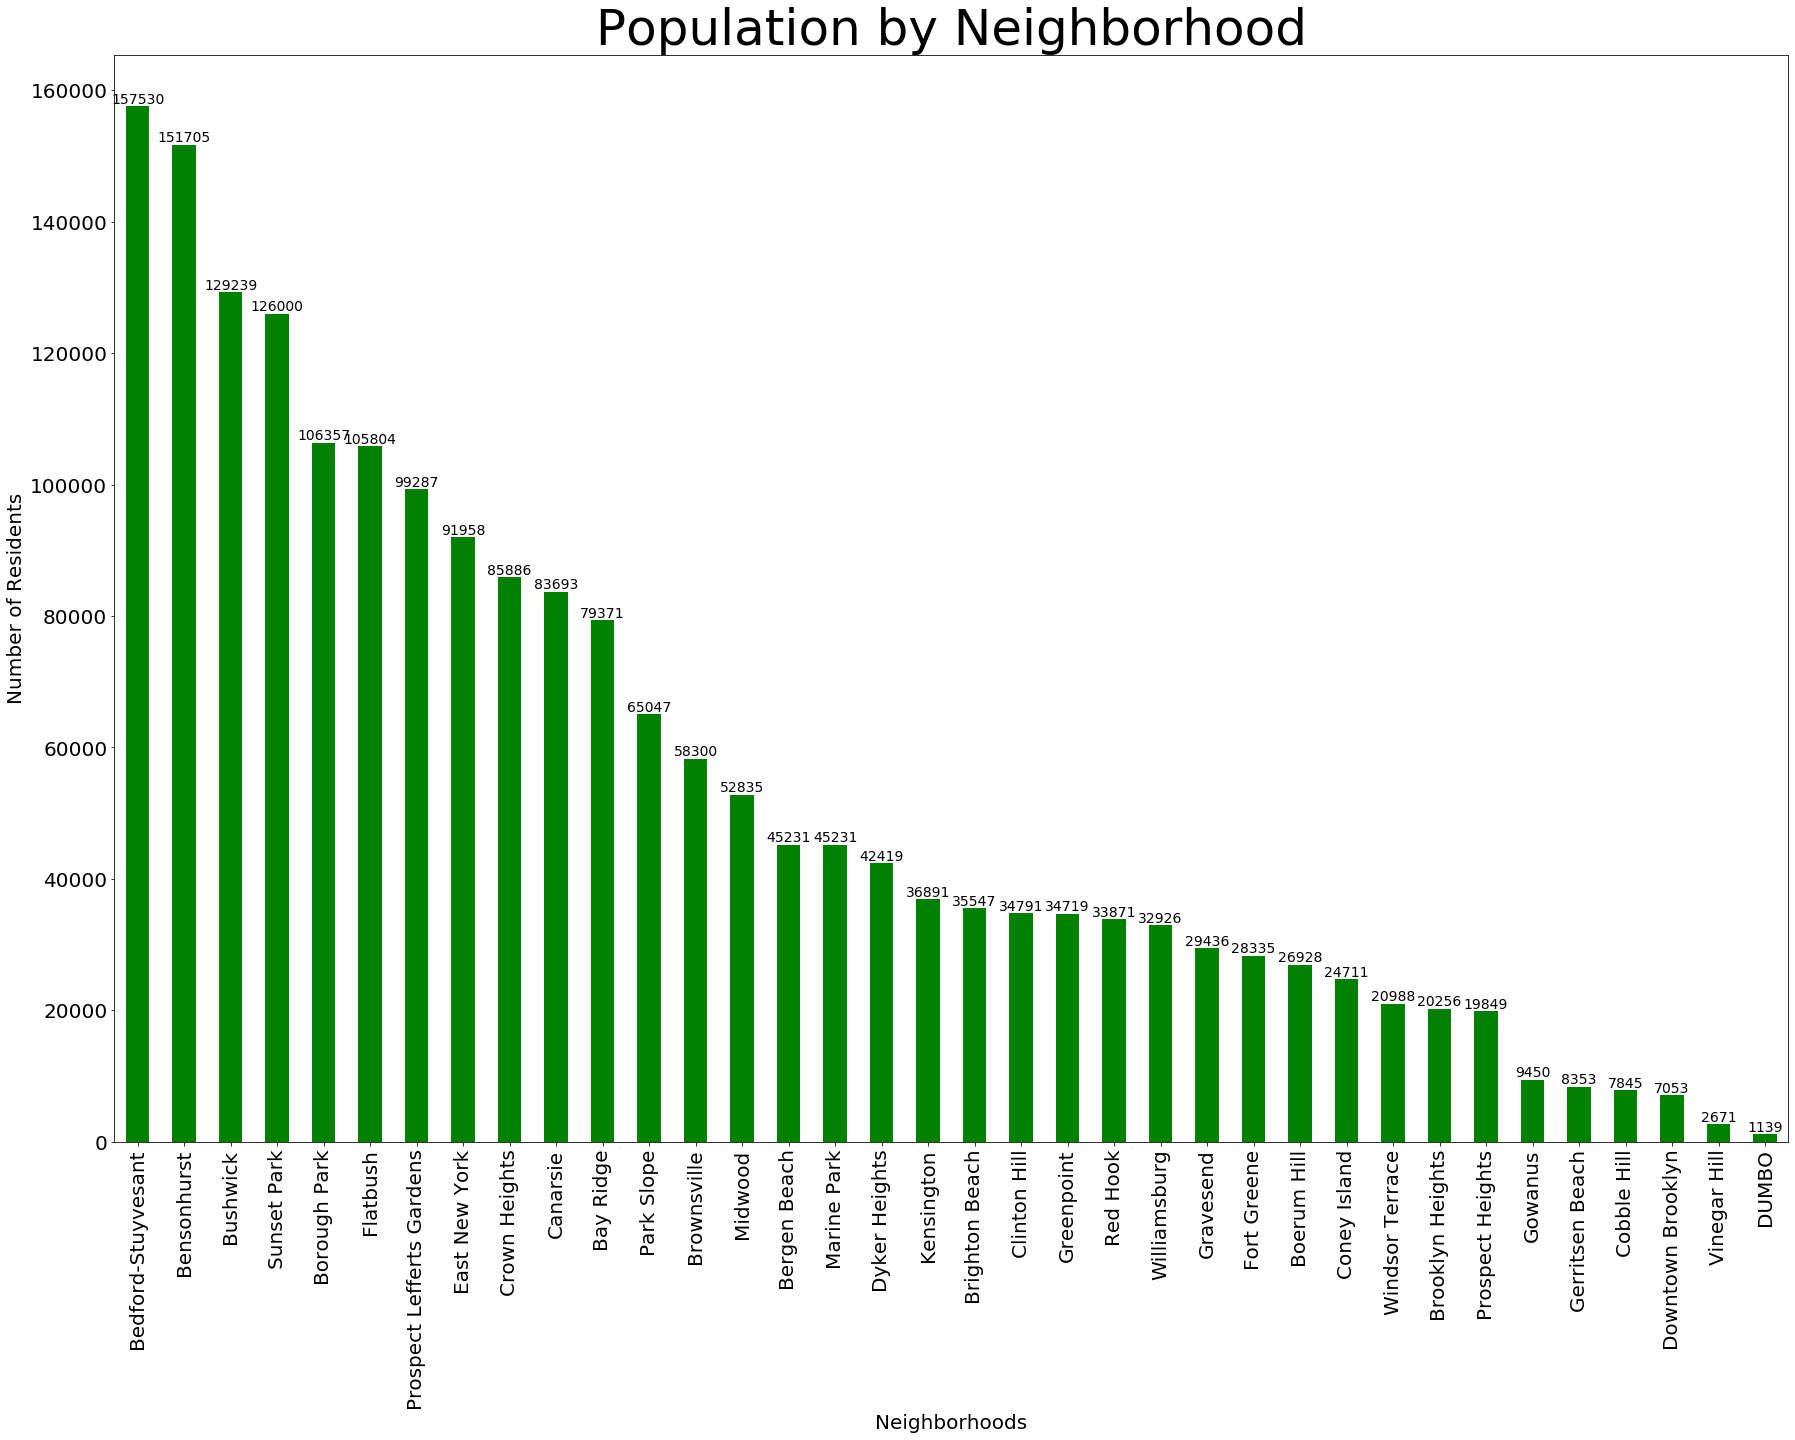

In [23]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
#set font sizes for the chart

SM = 8
MED = 14
LARGE = 20
SUPER = 50

plt.rc('font', size=MED)          # controls default text sizes
plt.rc('axes', titlesize=SUPER)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=LARGE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=LARGE)    # fontsize of the tick labels

bfig1 = plt.figure()
axfig1 = bneighs['Population'].plot(kind='bar',figsize=(30,20),color='GREEN')
axfig1.set_title('Population by Neighborhood')
axfig1.set_xlabel('Neighborhoods')
axfig1.set_ylabel('Number of Residents')

#rotate the x label 90 degrees
for tick in axfig1.get_xticklabels():

  tick.set_rotation(90)


# function to add labels on top of the bars
def add_value_labels(ax, typ, spacing=0):
    space = spacing
    va = 'bottom'

    if typ == 'bar':
        for i in ax.patches:
            y_value = i.get_height()
            x_value = i.get_x() + i.get_width() / 2

            label = "{:.0f}".format(y_value)
            ax.annotate(label,(x_value, y_value), xytext=(0, space), 
                    textcoords="offset points", ha='center', va=va)     
    if typ == 'line':
        line = ax.lines[0]
        for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
            label = "{:.2f}".format(y_value)
            ax.annotate(label,(x_value, y_value), xytext=(0, space), 
                textcoords="offset points", ha='center', va=va)   

add_value_labels(axfig1, typ='bar')

plt.savefig('neigh_bar_fig1.png')

### Create a map of Brooklyn neighborhoods

In [24]:
# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# create map of Brooklyn using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Borough'], brooklyn_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  

map_brooklyn.save('map_brooklyn.png')    
map_brooklyn


### Get a count of every skate park by Neighbourhood

In [25]:
skate_parks.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance (in miles)
Neighborhood,,,,,,,
Bath Beach,2,2,2,2,2,2,2
Bay Ridge,3,3,3,3,3,3,3
Bedford Stuyvesant,13,13,13,13,13,13,13
Bensonhurst,3,3,3,3,3,3,3
Bergen Beach,4,4,4,4,4,4,4
Boerum Hill,16,16,16,16,16,16,16
Borough Park,6,6,6,6,6,6,6
Brighton Beach,4,4,4,4,4,4,4
Broadway Junction,6,6,6,6,6,6,6


### Map both neignborhoods and skate parks

In [26]:
# create map of using latitude and longitude values
map_brooklyn_skate = folium.Map(location=[latitude, longitude], zoom_start=11)

# add neighborhood markers to map
for lat, lng, label in zip(skate_parks['Neighborhood Latitude'], skate_parks['Neighborhood Longitude'], skate_parks['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn_skate)  
    
# add skate park markers to map
for lat2, lng2, label2 in zip(skate_parks['Venue Latitude'], skate_parks['Venue Longitude'], skate_parks['Venue']):
    label2 = folium.Popup(label2, parse_html=True)
    folium.Marker(
        [lat2, lng2],
        popup=label2,

        ).add_to(map_brooklyn_skate)  

map_brooklyn_skate.save('map_brooklyn_skate.png')
map_brooklyn_skate

In [27]:
# one hot encoding
skate_onehot = pd.get_dummies(skate_parks[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
skate_onehot['Neighborhood'] = skate_parks['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [skate_onehot.columns[-1]] + list(skate_onehot.columns[:-1])
skate_onehot = skate_onehot[fixed_columns]

skate_onehot.shape

(552, 2)

### Group the Neighbourhoods and get the counts of the skate parks

In [28]:
skate_grouped = skate_onehot.groupby('Neighborhood').count().reset_index()
skate_grouped

,Neighborhood,Skate Park
0,Bath Beach,2
1,Bay Ridge,3
2,Bedford Stuyvesant,13
3,Bensonhurst,3
4,Bergen Beach,4
5,Boerum Hill,16
6,Borough Park,6
7,Brighton Beach,4
8,Broadway Junction,6
9,Brooklyn Heights,18


### Dropping the Neighbourhood column

In [29]:
skate_grouped_clustering = skate_grouped.drop('Neighborhood', 1)
skate_grouped_clustering.head()

,Skate Park
0,2
1,3
2,13
3,3
4,4


### Determine k for K-means by using the Elbow Method

[4.811594202898551, 1.9798876072168001, 1.348484118959346, 1.0880992252411803, 0.8713738368910782, 0.7493931605625758, 0.5704508856682767, 0.5122542513846859, 0.4200023004370829]


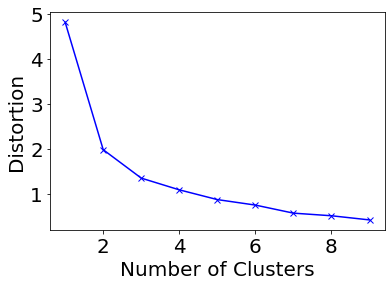

<Figure size 432x288 with 0 Axes>

In [30]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

distortions = []

K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(skate_grouped_clustering)
    kmeanModel.fit(skate_grouped_clustering)
    distortions.append(sum(np.min(cdist(skate_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / skate_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')

print(distortions)

plt.show()
plt.savefig('k_k-means.png')

### Based on the above, k should be 3

In [31]:
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(skate_grouped_clustering)

In [32]:
# add clustering labels
skate_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

brooklyn_merged = brooklyn_data

# merge brooklyn_merged with skate_grouped to add latitude/longitude for each neighborhood
brooklyn_merged = brooklyn_merged.join(skate_grouped.set_index('Neighborhood'), on='Neighborhood')

brooklyn_merged = brooklyn_merged[brooklyn_merged['Skate Park'].notna()]
brooklyn_merged['Cluster Labels'] = brooklyn_merged['Cluster Labels'].astype(int) #need to convert the labels from str to int
brooklyn_merged['Skate Park'] = brooklyn_merged['Skate Park'].astype(int) #need to convert the labels from str to int
brooklyn_merged.sort_values(by='Neighborhood', inplace=True) # sort
brooklyn_merged.head(10)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Skate Park
33,Brooklyn,Bath Beach,40.599519,-73.998752,0,2
0,Brooklyn,Bay Ridge,40.625801,-74.030621,0,3
17,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,1,13
1,Brooklyn,Bensonhurst,40.611009,-73.995180,0,3
45,Brooklyn,Bergen Beach,40.615150,-73.898556,0,4
41,Brooklyn,Boerum Hill,40.685683,-73.983748,2,16
34,Brooklyn,Borough Park,40.633131,-73.990498,0,6
5,Brooklyn,Brighton Beach,40.576825,-73.965094,0,4
64,Brooklyn,Broadway Junction,40.677861,-73.903317,0,6
18,Brooklyn,Brooklyn Heights,40.695864,-73.993782,2,18


### Sorting by the Skate Park column (the number of skate parks) for later analysis

In [33]:
brooklyn_merged.sort_values(by='Skate Park', inplace=True) # sort
brooklyn_merged.head(10)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Skate Park
32,Brooklyn,Coney Island,40.574293,-73.988683,0,1
28,Brooklyn,Canarsie,40.635564,-73.902093,0,1
33,Brooklyn,Bath Beach,40.599519,-73.998752,0,2
27,Brooklyn,Starrett City,40.647589,-73.879370,0,2
4,Brooklyn,Gravesend,40.595260,-73.973471,0,2
59,Brooklyn,Paerdegat Basin,40.631318,-73.902335,0,2
53,Brooklyn,Fort Hamilton,40.614768,-74.031979,0,3
66,Brooklyn,Homecrest,40.598525,-73.959185,0,3
35,Brooklyn,Dyker Heights,40.619219,-74.019314,0,3
52,Brooklyn,Ocean Parkway,40.613060,-73.968367,0,3


### Plot the Clusters on the map of Brooklyn

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-3],
        fill=True,
        fill_color=rainbow[cluster-3],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('map_cluster.png')
map_clusters

In [35]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[1] + list(range(4, brooklyn_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Skate Park
32,Coney Island,0,1
28,Canarsie,0,1
33,Bath Beach,0,2
27,Starrett City,0,2
4,Gravesend,0,2
59,Paerdegat Basin,0,2
53,Fort Hamilton,0,3
66,Homecrest,0,3
35,Dyker Heights,0,3
52,Ocean Parkway,0,3


In [36]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[1] + list(range(4, brooklyn_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Skate Park
11,Kensington,1,8
63,Weeksville,1,9
16,Bushwick,1,9
42,Prospect Lefferts Gardens,1,9
12,Windsor Terrace,1,9
21,Red Hook,1,10
24,Park Slope,1,11
9,Crown Heights,1,11
22,Gowanus,1,12
17,Bedford Stuyvesant,1,13


In [37]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[1] + list(range(4, brooklyn_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Skate Park
3,Greenpoint,2,16
41,Boerum Hill,2,16
61,Fulton Ferry,2,17
51,South Side,2,17
50,North Side,2,17
18,Brooklyn Heights,2,18
65,Dumbo,2,18
15,Williamsburg,2,18
62,Vinegar Hill,2,19
40,Downtown,2,20
